In [1]:
import json
import random
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import model_selection
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa

In [2]:
df_train=pd.read_csv("train_set.csv")
df_test=pd.read_csv("test_set.csv")
df_val=pd.read_csv("val_set.csv")

In [3]:
tr_sents=df_train.txt.tolist()
val_sents=df_val.txt.tolist()
test_sents=df_test.txt.tolist()

In [4]:
def generate_data(lines):
 
    x, y = [], []       
    for line in lines:
        x.append([])
        y.append([])
        words = line.strip().split()
        for word_i, word in enumerate(words):
            x[-1].append(word)
            label = 'O'
            if word_i == 0:
                label="B"

            y[-1].append(label)
    x_,X,y_,Y=[],[],[],[]
    
    #total sentences
    for i in range(0,len(x)-1,5):
        x_.append(chain(*zip(x[i:i+5])))
        y_.append(chain(*zip(y[i:i+5])))
    for i in x_:
        flat_list = [item for sublist in i for item in sublist]
        X.append(flat_list)
    for i in y_:
        flat_list = [item for sublist in i for item in sublist]
        Y.append(flat_list)
    
    return X, Y

In [7]:
#create biggest X
corpus_fpath = "all_sents.json"
X= json.load(open(corpus_fpath))
X=[i.strip().split() for i in X]

In [8]:
len(X)

39908

In [13]:
X_train,y_train=generate_data(tr_sents)
X_valid,y_valid=generate_data(val_sents)
X_test,y_test=generate_data(test_sents)

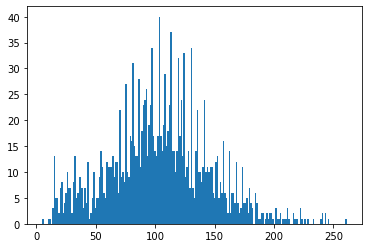

103.87418008348241
261


In [15]:
lengths = [len(t) for t in X_train]
max_length = max([len(t) for t in X_train])
plt.hist(lengths, bins=len(set(lengths)))
plt.show()
print(sum(lengths) / len(lengths))
print(max_length)

In [16]:
#tokenizer

tokenizer = Tokenizer(filters=None,oov_token="unk")

tokenizer.fit_on_texts(X)

print(tokenizer.texts_to_sequences([X_train[0]]))
print(X_train[0])

[[251, 262, 116344, 63, 133, 43478, 261, 133, 19349, 230, 235, 18563, 6662, 83, 156, 83, 83, 21, 66, 27, 2, 88, 3, 41, 92, 298, 139, 134, 312, 7, 2870, 3755, 2, 114, 117, 4, 13, 32, 9, 5, 82, 174, 197, 278]]
['Citation', 'Nr:', '0634451', 'Decision', 'Date:', '11/07/06', 'Archive', 'Date:', '11/16/06', 'DOCKET', 'NO.', '03-11', '289', ')', 'DATE', ')', ')', 'On', 'appeal', 'from', 'the', 'Department', 'of', 'Veterans', 'Affairs', '(VA)', 'Regional', 'Office', '(RO)', 'in', 'Detroit,', 'Michigan', 'THE', 'ISSUE', 'Entitlement', 'to', 'service', 'connection', 'for', 'a', 'right', 'knee', 'disability.', 'REPRESENTATION']


In [20]:
vocab_length = len(tokenizer.word_index) + 1

In [18]:
words=list(tokenizer.word_index)
words[0]

'unk'

In [19]:
words[-1]

'stressors/sleep'

In [22]:
tokenizer.word_index["end_word"]=vocab_length

In [23]:
words.append("end_word")

In [24]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=150, padding='post',value=vocab_length)
    return padded_sequences

In [25]:
X_train_sequnces,X_valid_sequnces,X_test_sequnces=[],[],[]

In [26]:
X_train_sequences = get_sequences(tokenizer, X_train)
X_valid_sequences = get_sequences(tokenizer, X_valid)
X_test_sequences = get_sequences(tokenizer, X_test)

In [27]:
X_valid_sequences.shape

(134, 150)

In [28]:
classes = ["B","O"]

In [29]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
classes_to_index

{'B': 0, 'O': 1}

In [30]:
y_train_s = [[classes_to_index.get(w) for w in s]for s in y_train]
y_valid_s = [[classes_to_index.get(w) for w in s]for s in y_valid]
y_test_s = [[classes_to_index.get(w) for w in s]for s in y_test]


In [31]:
X_valid_sequences.shape

(134, 150)

In [32]:
y_train_sequences = pad_sequences(maxlen = 150 , sequences =y_train_s, padding='post',value=1)
y_valid_sequences=pad_sequences(maxlen = 150 , sequences =y_valid_s, padding='post',value=1)
y_test_sequences=pad_sequences(maxlen = 150 , sequences =y_test_s, padding='post',value=1)

In [33]:
#one hot encoding
y_train_sequences = [to_categorical(i, num_classes=2) for i in y_train_sequences]
y_valid_sequences = [to_categorical(i, num_classes=2) for i in y_valid_sequences]
y_test_sequences = [to_categorical(i, num_classes=2) for i in y_test_sequences]

In [34]:
y_valid_sequences[0].shape

(150, 2)

In [35]:
from numpy import array,asarray,zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B/glove.6B.300d.txt', encoding="utf8")

In [36]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [42]:
embedding_matrix = zeros((vocab_length+1, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [43]:
#embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False)

In [104]:
input_word = Input(shape = (150,))
model = Embedding(vocab_length+1,output_dim=300, weights=[embedding_matrix],input_length=32)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(2,activation='sigmoid'))(model)
model = Model(input_word,out)
model.compile(optimizer=tfa.optimizers.Yogi(),loss=tfa.losses.SigmoidFocalCrossEntropy(),metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
#model.compile(optimizer="adam",loss=tfa.losses.SigmoidFocalCrossEntropy(),metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 150, 300)          73161900  
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 150, 300)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 150, 200)          320800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 150, 2)            402       
Total params: 73,483,102
Trainable params: 73,483,102
Non-trainable params: 0
_________________________________________________________________


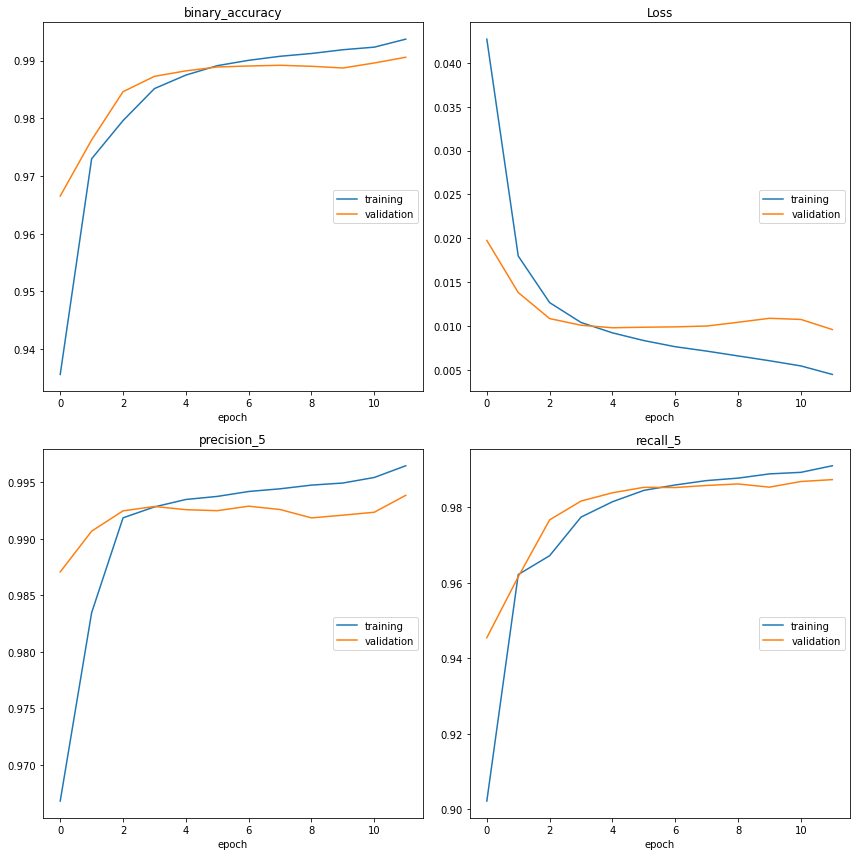

binary_accuracy
	training         	 (min:    0.936, max:    0.994, cur:    0.994)
	validation       	 (min:    0.967, max:    0.991, cur:    0.991)
Loss
	training         	 (min:    0.004, max:    0.043, cur:    0.004)
	validation       	 (min:    0.010, max:    0.020, cur:    0.010)
precision_5
	training         	 (min:    0.967, max:    0.996, cur:    0.996)
	validation       	 (min:    0.987, max:    0.994, cur:    0.994)
recall_5
	training         	 (min:    0.902, max:    0.991, cur:    0.991)
	validation       	 (min:    0.945, max:    0.987, cur:    0.987)
27/27 [==============================] - 47s 2s/step - loss: 0.0045 - binary_accuracy: 0.9937 - precision_5: 0.9965 - recall_5: 0.9910 - val_loss: 0.0096 - val_binary_accuracy: 0.9906 - val_precision_5: 0.9938 - val_recall_5: 0.9873


In [105]:
#early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback()]#,early_stopping]

#imbalanced dataset:


history = model.fit(
    X_train_sequences,np.array(y_train_sequences),
    validation_data =(X_valid_sequences,np.array(y_valid_sequences)) ,
    batch_size = 64,
    epochs = 12,
    verbose = 1,
    callbacks=callbacks
)

In [106]:
model.evaluate(X_test_sequences, np.array(y_test_sequences))

6/6 [==============================] - 2s 257ms/step - loss: 0.0129 - binary_accuracy: 0.9876 - precision_5: 0.9920 - recall_5: 0.9831


[0.01290600374341011,
 0.9875828623771667,
 0.9919751286506653,
 0.9831188917160034]

In [107]:
i = np.random.randint(0, X_test_sequences.shape[0])
p = model.predict(np.array([X_test_sequences[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test_sequences), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(X_test_sequences[i], y_true, p[0]):
  print("{:15}{:5}\t{}".format(words[w-1], classes[true],classes[pred]))

Word           True 	 Pred

------------------------------
the            B    	B
preponderance  O    	O
of             O    	O
the            O    	O
evidence       O    	O
must           O    	O
be             O    	O
against        O    	O
the            O    	O
claim          O    	O
for            O    	O
benefits       O    	O
to             O    	O
be             O    	O
denied.        O    	O
see            B    	B
alemany        O    	O
v.             O    	O
brown,         O    	O
9              O    	O
vet.           O    	O
app.           O    	O
518            O    	O
(1996).        O    	O
analysis       B    	B
the            B    	B
veteran        O    	O
contends       O    	O
that           O    	O
he             O    	O
developed      O    	O
sleep          O    	O
apnea          O    	O
when           O    	O
he             O    	O
was            O    	O
deployed       O    	O
to             O    	O
afghanistan    O    	O
from           O    	O
2008           O    	

In [108]:
Y_pred = model.predict(np.array(X_test_sequences))
y_pred = np.array([np.argmax(pred,axis=-1) for pred in Y_pred])

In [109]:
probs=Y_pred.max(axis=-1).ravel()

In [110]:
y_true=[]

In [111]:
for i in range(0,171):
    y_true.append(np.argmax(np.array(y_test_sequences), axis=-1)[i])

In [112]:
f_y_test = list(chain.from_iterable(y_true))
f_pred_y = list(chain.from_iterable(y_pred))

In [113]:
array=confusion_matrix(f_y_test, f_pred_y)

<AxesSubplot:>

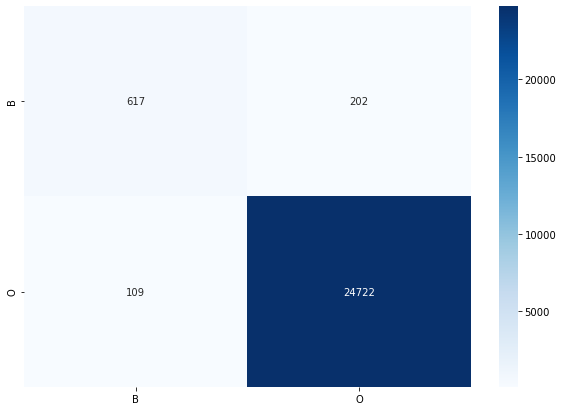

In [114]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

In [115]:
print(classification_report(f_y_test, f_pred_y))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80       819
           1       0.99      1.00      0.99     24831

    accuracy                           0.99     25650
   macro avg       0.92      0.87      0.90     25650
weighted avg       0.99      0.99      0.99     25650

